# Imports

In [19]:
import matplotlib.pyplot as plt
import cv2
import sys

from glob import glob
from keras.models import model_from_json
from PIL import Image
from scipy import ndimage

sys.path.append('EAST')
sys.path.append('scripts')
sys.path.append('image-super-resolution')
from eval import *
from helpers import *
from ISR.models import RDN

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# Load image

In [3]:
# Load in test image in RGB
img = cv2.imread('data/test_img.jpg', -1)[:, :, ::-1]

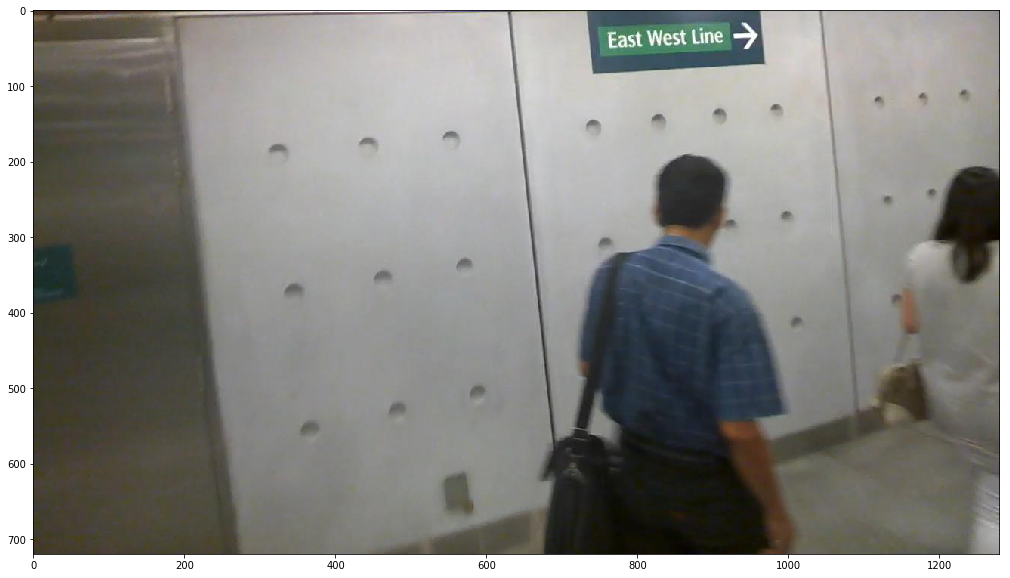

In [4]:
plt.figure(figsize=(20, 10))
plt.imshow(img)

# 1. Determine polygon surrounding text

In [5]:
with open('saved_models/east_model.json', 'r') as f:
    loaded_model_json = f.read()

east_model = model_from_json(loaded_model_json, custom_objects={'tf': tf, 'RESIZE_FACTOR': 2})
east_model.load_weights('saved_models/EAST_IC15+13_model.h5')

In [6]:
polys = run_east_model([img], east_model)

In [7]:
# Select the text box of interest
poly = np.squeeze(polys[0][0])

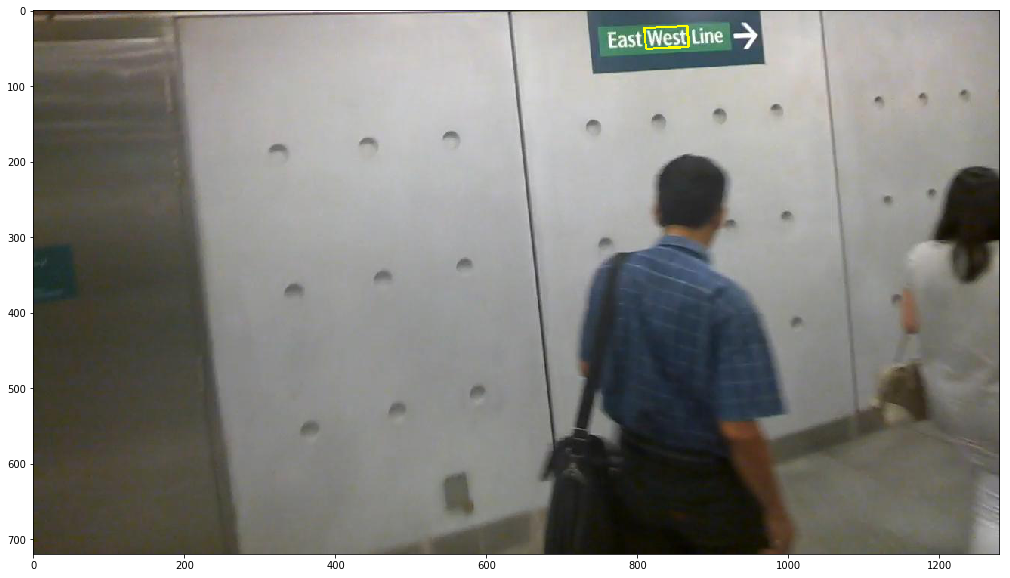

In [8]:
east_img = img.copy()
cv2.polylines(east_img, [poly.astype(np.int32).reshape((-1, 1, 2))], True, (255, 255, 0), 2)    
plt.figure(figsize=(20, 10))
plt.imshow(east_img)

# 2. Transform view of text to birds-eye perspective

In [9]:
text_img, coordinates, trans_matrix = four_point_transform(img, poly)

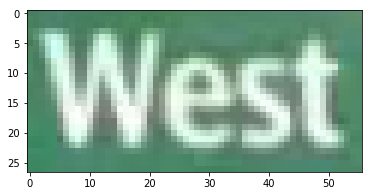

In [10]:
plt.imshow(text_img)

# 3. Increase resolution 

In [12]:
rdn = RDN(arch_params={'C':6, 'D':20, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('image-super-resolution/weights/sample_weights/rdn-C6-D20-G64-G064-x2/ArtefactCancelling/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5')

In [13]:
sr_text_img = rdn.predict(text_img)

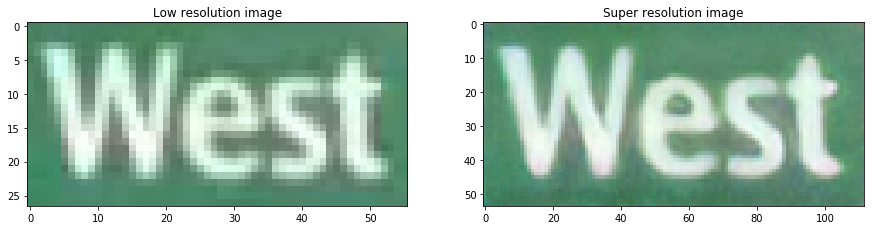

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax[0].set_title('Low resolution image')
ax[0].imshow(text_img)

ax[1].set_title('Super resolution image')
ax[1].imshow(sr_text_img)

# 4. Prepare image of text for OCR

## 4.1 Threshold

In [15]:
gray_text_img = cv2.cvtColor(sr_text_img, cv2.COLOR_RGB2GRAY)
thresh_text_img = cv2.adaptiveThreshold(gray_text_img, maxValue=255, adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        thresholdType=cv2.THRESH_BINARY, blockSize=77, C=3)

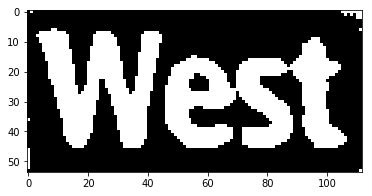

In [16]:
plt.imshow(thresh_text_img, 'gray')

## 4.2 Determine if black text on white or vice versa

In [17]:
is_black_on_white = ((np.sum(thresh_text_img[:, 0]) + np.sum(thresh_text_img[0, :]) + 
                      np.sum(thresh_text_img[:, -1]) + np.sum(thresh_text_img[-1, :])) 
                     / (2 * thresh_text_img.shape[0] + 2 * thresh_text_img.shape[1])) > 255 / 2

print('The {} text is on a {} background.'.format('black' if is_black_on_white else 'white', 
                                                 'white' if is_black_on_white else 'black'))

The white text is on a black background.


## 4.3 Filter out noise

In [20]:
blob_threshold = 50
labeled_text_img, num_objs = ndimage.label(
    thresh_text_img < blob_threshold) if is_black_on_white else ndimage.label(thresh_text_img > blob_threshold)

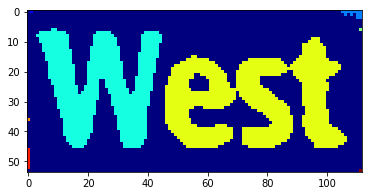

In [21]:
plt.imshow(labeled_text_img, 'jet')

In [23]:
masks = [(labeled_text_img == idx_obj) for idx_obj in range(num_objs + 1)]

In [24]:
# remove masked background
max_value = max([np.sum(mask) for mask in masks])
masks_without_back = [mask for mask in masks if np.sum(mask) != max_value]

In [27]:
 # Remove small blobs 
filter_threshold = masks[0].shape[0] * masks[0].shape[1] * 0.005
print('Every blob having less than {:.0f} pixels will be filtered out.'.format(filter_threshold))
avg_pixels = np.sum(masks_without_back) / len(masks_without_back)
filtered_masks = [mask for mask in masks_without_back if np.sum(mask) > filter_threshold]

Every blob having less than 30 pixels will be filtered out.


In [28]:
filtered_text_img = (sum(filtered_masks) * 255).astype('uint8')

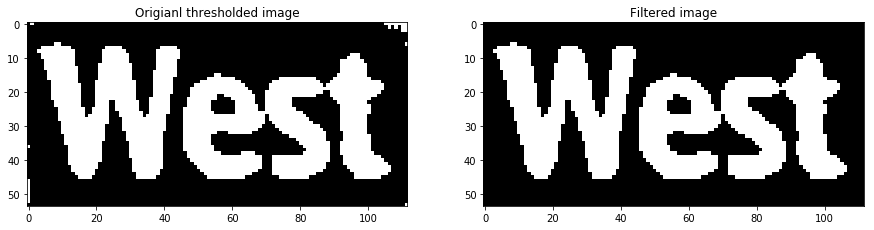

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax[0].set_title('Origianl thresholded image')
ax[0].imshow(thresh_text_img, 'gray')
ax[1].set_title('Filtered image')
ax[1].imshow(filtered_text_img, 'gray')

## 4.4 Increase canvas size

In [31]:
canvas_factor = 0.2
bigger_text_img = cv2.copyMakeBorder(filtered_text_img, 
                                     top=int(filtered_text_img.shape[0]*canvas_factor), 
                                     bottom=int(filtered_text_img.shape[0]*canvas_factor), 
                                     left=int(filtered_text_img.shape[1]*canvas_factor),
                                     right=int(filtered_text_img.shape[1]*canvas_factor), 
                                borderType=cv2.BORDER_CONSTANT, value=0)

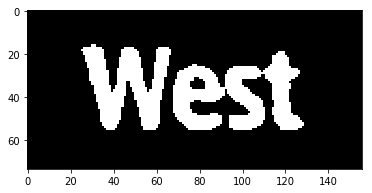

In [32]:
plt.imshow(bigger_text_img, 'gray')

## 4.5 Invert colors to get black on white image

In [33]:
inv_text_img = np.invert(bigger_text_img)

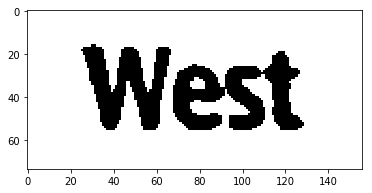

In [34]:
plt.imshow(inv_text_img, 'gray')

## 4.6 Thin out the characters by dilating the image

In [35]:
kernel_size = 2
dilated_text_img = dilate_img(inv_text_img, kernel_size=kernel_size, iterations=1)

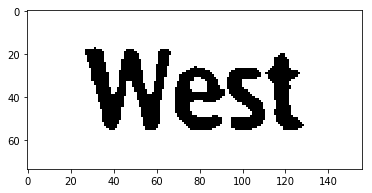

In [36]:
plt.imshow(dilated_text_img, 'gray')

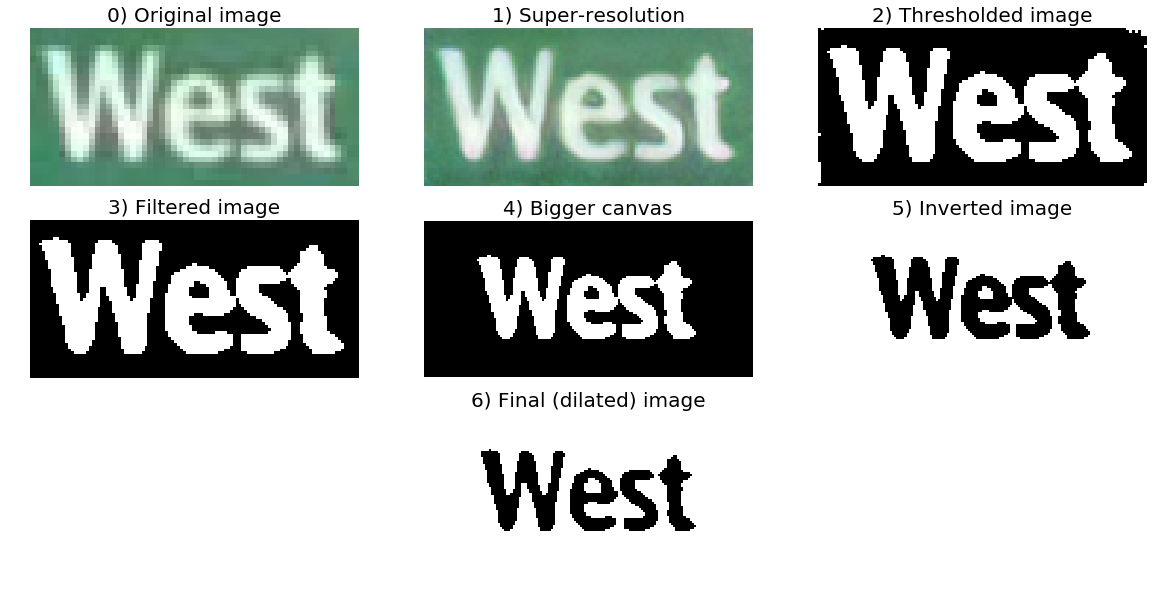

In [65]:
# Visualize the complete preprocessing steps
nrows, ncols = 3, 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
for row in range(nrows):
    for col in range(ncols):
        ax[row][col].axis('off')

ax[0][0].set_title('0) Original image', fontsize=20)
ax[0][0].imshow(text_img)
ax[0][1].set_title('1) Super-resolution', fontsize=20)
ax[0][1].imshow(sr_text_img)
ax[0][2].set_title('2) Thresholded image', fontsize=20)
ax[0][2].imshow(thresh_text_img, 'gray')
ax[1][0].set_title('3) Filtered image', fontsize=20)
ax[1][0].imshow(filtered_text_img, 'gray')
ax[1][1].set_title('4) Bigger canvas', fontsize=20)
ax[1][1].imshow(bigger_text_img, 'gray')
ax[1][2].set_title('5) Inverted image', fontsize=20)
ax[1][2].imshow(inv_text_img, 'gray')
ax[2][0].set_axis_off()
ax[2][2].set_axis_off()
ax[2][1].set_title('6) Final (dilated) image', fontsize=20)
ax[2][1].imshow(dilated_text_img, 'gray')

# 5. Read text using pytesseract OCR

In [53]:
whitelist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
ocr = get_ocr_data(dilated_text_img, whitelist=whitelist)
ocr

{'level': [1, 2, 3, 4, 5],
 'page_num': [1, 1, 1, 1, 1],
 'block_num': [0, 1, 1, 1, 1],
 'par_num': [0, 0, 1, 1, 1],
 'line_num': [0, 0, 0, 1, 1],
 'word_num': [0, 0, 0, 0, 1],
 'left': [0, 27, 27, 27, 27],
 'top': [0, 17, 17, 17, 17],
 'width': [156, 102, 102, 102, 102],
 'height': [74, 39, 39, 39, 39],
 'conf': [-1, -1, -1, -1, 96],
 'text': ['', '', '', '', 'West']}

## 5.1 Filter results based on the confidence of the OCR

In [54]:
# Filter the results of the OCR based on the confidence levels
conf_threshold = 70
filtered_ocr = filter_ocr_result(ocr, threshold=conf_threshold)
filtered_ocr

defaultdict(list,
            {'level': [5],
             'page_num': [1],
             'block_num': [1],
             'par_num': [1],
             'line_num': [1],
             'word_num': [1],
             'left': [27],
             'top': [17],
             'width': [102],
             'height': [39],
             'conf': [96],
             'text': ['West'],
             'valid_colors': [(0, 0, 255)]})

## 5.2 Get the exact position of the text using the result from the OCR

In [55]:
reversed_polys = reverse_ocr_polys(
    (text_img, coordinates, trans_matrix), sr_text_img.shape, filtered_ocr, canvas_factor)

In [56]:
ocr_img = east_img.copy()

for idx_poly, (poly, text, conf) in enumerate(zip(reversed_polys, filtered_ocr['text'], filtered_ocr['conf'])):
    cv2.polylines(ocr_img, [poly.reshape((-1, 1, 2))], True, (0, 255, 0), 2)
    cv2.putText(ocr_img, '{} {}%'.format(text, conf), tuple(poly[2] + 15), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

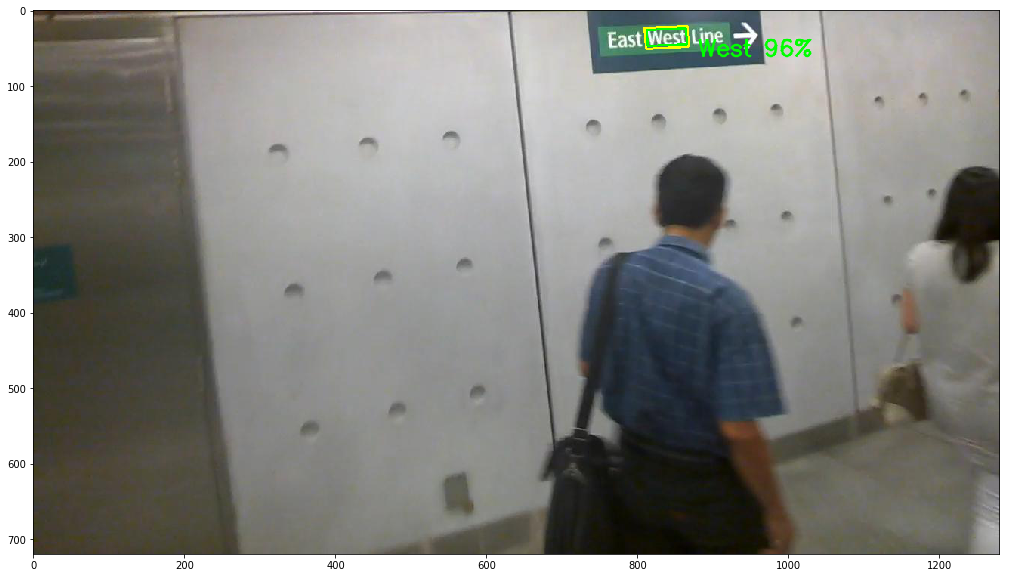

In [57]:
plt.figure(figsize=(20, 10))
plt.imshow(ocr_img)